In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import json
import os
import sqlite3
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from IPython.display import HTML, display, Markdown
from itertools import combinations
from clustering import prep_data_for_clustering, get_kdist, \
    display_pca_views, kmeans_proper, cluster_range, \
    plot_clusters2, plot_internal, heirarch_cluster, \
    print_cluster_metrics, kmed_proper, format_with_commas

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.metrics import silhouette_score

C:\Users\vsitu\AppData\Local\Temp\ipykernel_10068\4270675161.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


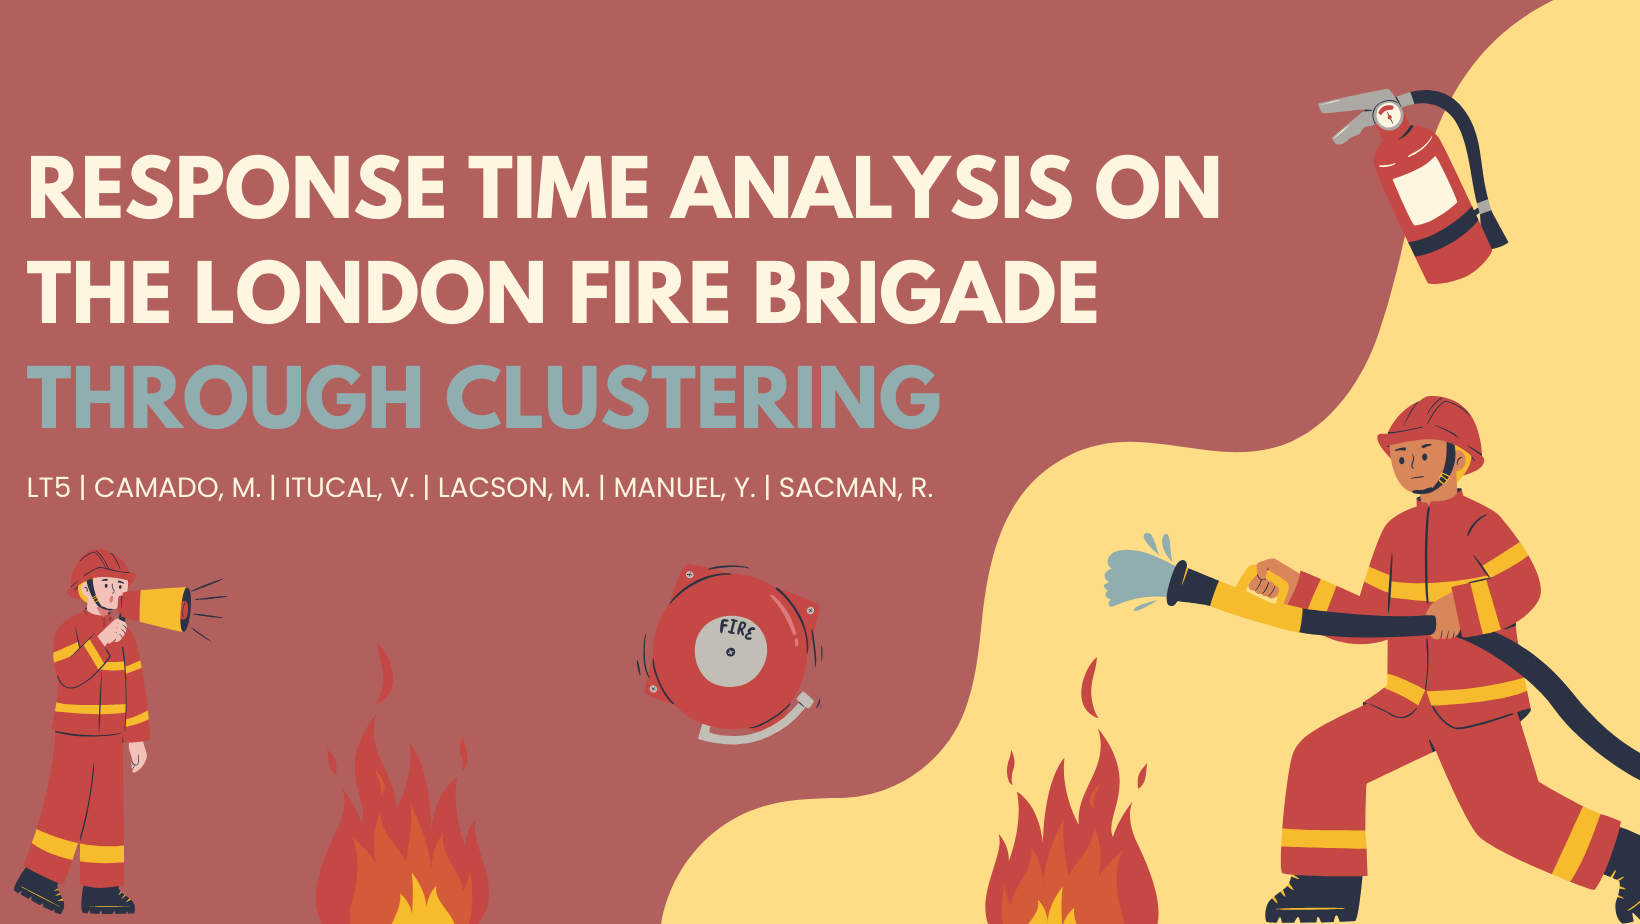

## Abstract

xxx

## Introduction

### London Fire Brigade

Established in 1866, the London Fire Brigade (LFB) is a leading firefighting and rescue organization, dedicated to ensuring London's safety. Efficiency is paramount as they respond swiftly to diverse incidents like special service calls, fires, and false alarms. With a mission to make London safer, the LFB plays a vital role in public safety through its rapid and effective responses.

To achieve this, the team will conduct a detailed analysis of the response time, property features, resource allocation and expenses patterns for fire incident types. From the features mentioned, the team aims to assess and recommend optimizations on the historical LFB Team processes by looking into their defined metrics in their LFB dataset. The team's approach is to conduct different clustering methods and see what works with the data and uncover clusters from chosen ideal clustering methods.

### Problem Statement

This analysis aims to uncover response time, property features, resource allocation and expenses patterns in fire incidents with the goal of assessing and suggesting how the LFB team responds to a fire incident.

## Methodology

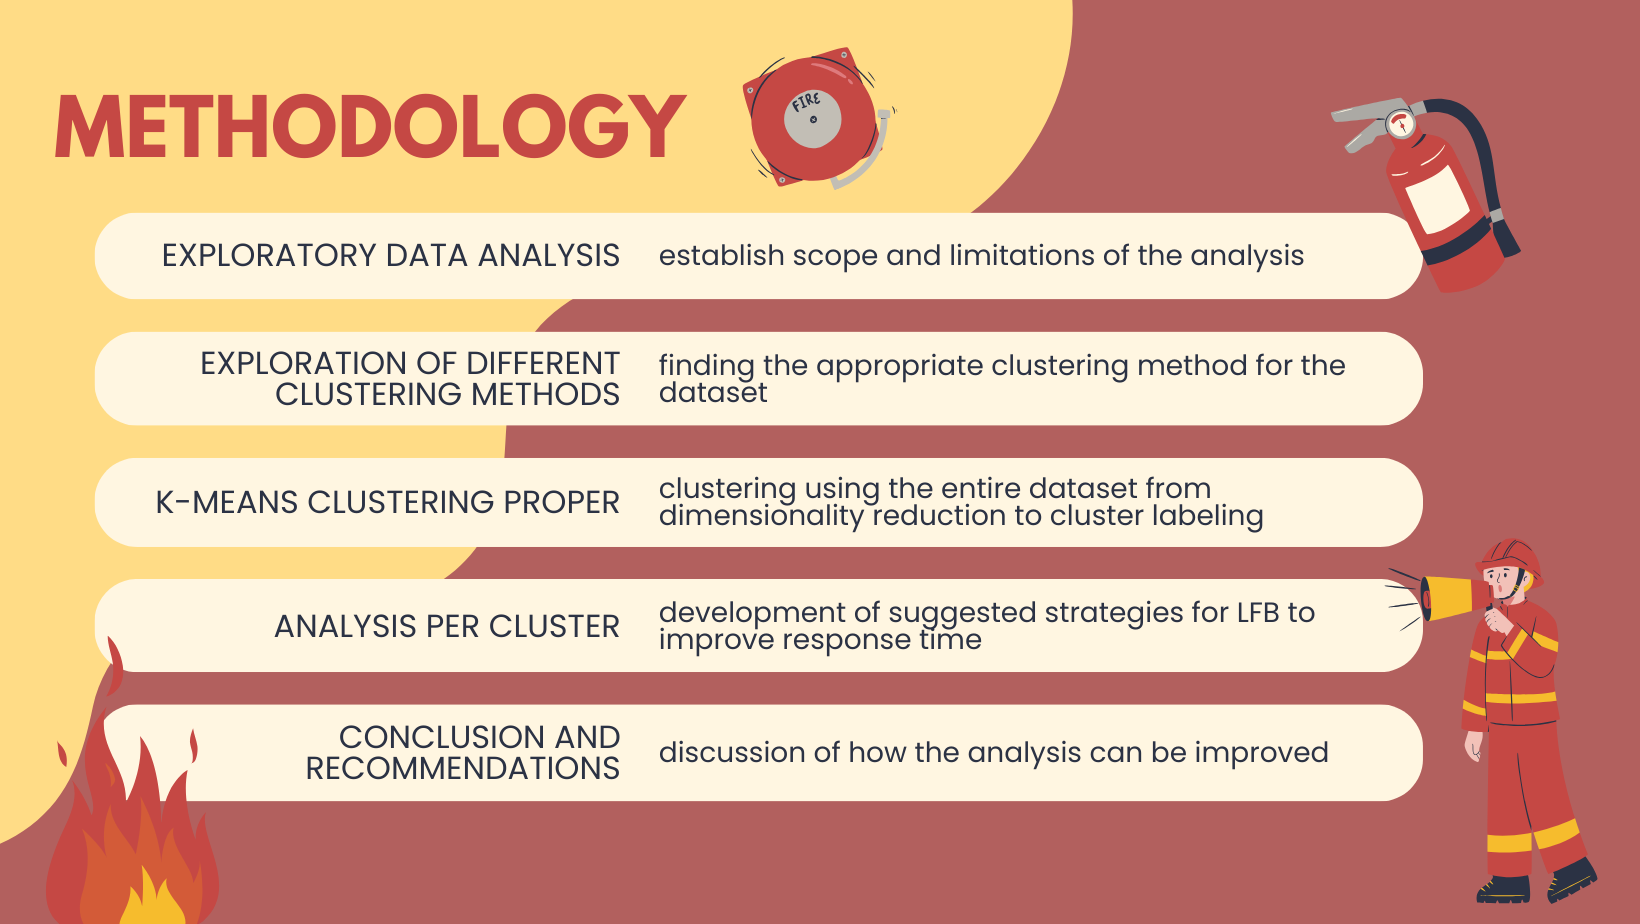

## Data Source

The London Fire Brigade's (LFB) incident data from January 2020 to August 2023 was chosen as the dataset for this analysis since the nature of this study is to improve the system's current response time and develop targeted strategies. With this, it is essential to know the status of LFB's current system and improve on this further. The dataset wIll be placed in a sqlite database for easier data manipulation and exploration.

In [3]:
if not os.path.exists('lfb.db'):
    directory = '/mnt/data/public/lfb/'
    files = os.listdir(directory)
    lfb_data = files[7]  # lfb incident data from 202001 to 202308
    
    print("SQLite DB does not exist. Loading csv dataset to the db again...")
    df = pd.read_excel(os.path.join(directory, lfb_data))
    display(df.head())
    conn = sqlite3.connect('lfb.db')
    df.to_sql('incidents_202001_202308', conn,
              if_exists='replace', index_label=None)
    conn.commit()
    print("Dataset loaded to SQLite DB.")
else:
    print("SQLite DB already exists.")
    conn = sqlite3.connect('lfb.db')
    print("Connection established with SQLite DB.")

SQLite DB already exists.
Connection established with SQLite DB.


In [4]:
query = "SELECT * FROM incidents_202001_202308"
display_df = pd.read_sql(query, conn)
display_df = display_df.head()
display_df.style.set_table_attributes(
    "style='display:inline'").set_caption(
    'Table 1. London Fire Brigade Incident Data from January 2020\
    to August 2023').set_table_styles(
    [dict(selector = "caption", 
               props = [("text-align", "left")])])

The DataFrame above shows a snippet of the main dataset. Only specific columns that are essential in coming up with a coherent analysis will be used from this dataset. These said columns will be discussed in the next portion of this paper. For now, the table below shows a brief description of what each column in the main dataset means.

<center>Table 2. Dataset Column Descriptions</center>

| Column                             | Sample record      | Description                                            |
|:-----------------------------------|:-------------------|:-------------------------------------------------------|
| IncidentNumber                     | 000008-01012018    | LFB Incident Number                                    |
| DateOfCall                         | 01-Jan-18          | Date of 999 call                                       |
| CalYear                            | 2018               | Year of 999 call                                       |
| TimeOfCall                         | 0:04:25            | Time of 999 call                                       |
| HourOfCall                         | 0                  | Hour of 999 call                                       |
| IncidentGroup                      | False Alarm, Fire, Special | High level incident category                |
| PropertyCategory                   | Non Residential    | High level property descriptor                         |
| PropertyType                       | Mosque             | Detailed property descriptor                           |
| IncGeo_BoroughName                 | BARNET             | Borough Name                                           |
| IncidentStationGround              | Finchley           | LFB Station ground                                     |
| FirstPumpArriving_AttendanceTime   | 348                | First Pump attendance time in seconds                  |
| FirstPumpArriving_DeployedFromStation | Finchley        | First Pump deployed from station                       |
| SecondPumpArriving_AttendanceTime  |                    | Second Pump attendance time in seconds                 |
| SecondPumpArriving_DeployedFromStation |                | Second Pump deployed from station                      |
| NumStationsWithPumpsAttending      | 1                  | Inital Number of stations with pumps in attendance            |
| NumPumpsAttending                  | 1                  | Initial Number of pumps in attendance                          |
| PumpCount                          | 1                  | Total number of pumps at fires conclusion                                                       |
| PumpHoursRoundUp                 | 1                  | Time spent at incident by pumps |
| Notional Cost (£)                  | 328                | Time spent multiplied by notional annual cost of a pump |
| NumCalls                           | 1                  | Number of calls received about the incident            |

Notes: `pump` is slang for a firetruck

## Exploratory Data Analysis

Initial exploratory data analysis (EDA) was done to set the scope and limitations of the analysis and create a clearer picture of what the dataset looks like. Necessary decisions regarding the different parameters of the analysis were made based on findings from this EDA.

### Scope and Limitations

In [5]:
query = """
SELECT DISTINCT
    incidentnumber,
    COUNT(1) row_cnt
FROM incidents_202001_202308
GROUP BY 1 
ORDER BY 2 DESC
"""

display_df = pd.read_sql(query, conn)
display_df = display_df.head()
display_df.style.set_table_attributes(
    "style='display:inline'").set_caption('Table 3. Number of Rows per `IncidentNumber`')

The number of rows per `IncidentNumber` was obtained to make sure that the dataset is distinct by this dataset feature. It can be seen in <i>Table 3</i> that the dataset is indeed distinct by this column. With this, `IncidentNumber` will be used as an index for our analysis dataset.

In [6]:
query = """
SELECT DISTINCT
    calyear,
    MIN(DATE(dateofcall)) min_date,
    MAX(DATE(dateofcall)) max_date,
    COUNT(DISTINCT IncidentNumber) incident_cnt
FROM incidents_202001_202308
GROUP BY calyear
ORDER BY 1
"""

display_df = pd.read_sql(query, conn)
display_df.style.set_table_attributes(
    "style='display:inline'").set_caption('Table 4. Number of Incidents per Calendar Year')

In [1]:
### Visualization needed? Bar chart?

From <i>Table 4</i> above, it can be seen that the data available for the year 2023 is until August only. This will limit the study to analyze data until August 2023 only. Furthermore, an increasing number of incidents can be seen from 2020 to 2022. 

In [7]:
query = """
SELECT DISTINCT
    IncidentGroup,
    COUNT(DISTINCT IncidentNumber) incident_cnt
FROM incidents_202001_202308
GROUP BY 1
ORDER BY 2 DESC
"""

display_df = pd.read_sql(query, conn)
display_df.style.set_table_attributes(
    "style='display:inline'").set_caption('Table 5. Number of Incidents per `IncidentGroup`')

The number of incidents per `IncidentGroup` was obtained to see how many datapoints are available for each. It can be observed from <i>Table 5</i> that most of the datapoints are false alarms and only around 62,000 datapoints are for fire incidents. As the goal of this analysis is to uncover patterns of fire incidents and develop strategies for better response time, the dataset to be used for the analysis will be filtered to `IncidentGorup = 'Fire'` to analyze fire incidents alone.

### Dataset features used for clustering

Not all features in the main dataset will be utilized in the clustering proper. Below are the numerical features to be used in clustering:
- FirstPumpArriving_AttendanceTime (`first_pump_time`)
- SecondPumpArriving_AttendanceTime (`second_pump_time`)
- NumStationsWithPumpsAttending (`num_of_station_pumps`)
- NumPumpsAttending (`num_pumps`)
- PumpCount (`pump_cnt`)
- PumpHoursRoundUp (`pump_hrs_rnd_up`)
- Notional Cost (£) (`notional_cost`)
- NumCalls (`num_calls`)

These features were chosen since these are the metrics involved in fire response in terms of response time and resources allocated in dealing with a fire incident. All the leftover categorical variables will be used later in the labelling phase to bring out things that are most common inside the clusters that will be discovered.

In [8]:
query = """
SELECT DISTINCT
    IncidentNumber,
    FirstPumpArriving_AttendanceTime,
    SecondPumpArriving_AttendanceTime,
    NumStationsWithPumpsAttending,
    NumPumpsAttending,
    PumpCount,
    PumpHoursRoundUp,
    "Notional Cost (£)",
    NumCalls
FROM incidents_202001_202308
WHERE IncidentGroup = 'Fire'
"""

cluster_df = pd.read_sql(query, conn).set_index('IncidentNumber')
cluster_display_df = cluster_df.head()
cluster_display_df.style.set_table_attributes(
    "style='display:inline'").set_caption('Table 6. Dataset Features for Clustering')

Checking the distribution of the data as well as getting the measures of central tendency of each feature will give a clear picture of the dataset.

In [9]:
cluster_display_df = cluster_df.describe()
cluster_display_df.style.set_table_attributes(
    "style='display:inline'").set_caption('Table 7. Measures of Central Tendency of Features for Clustering')

From the table above, there are more non-null for the `FirstPumpArriving_AttendanceTime` compared to the `SecondPumpArriving_AttendanceTime`. This suggests that the latter feature is sparse. Imputing of null values for this feature will be discussed later on. The standard deviation of both said features are close to each other. For `Notional Cost`, this feature has a high standard deviation. This suggests that this feature may have outliers since the maximum value is far from the 75th percentile. The rest of the variables (`NumStationsWithPumpsAttending`, `NumPumpsAttending`, `PumpCount`, `PumpHoursRoundUp`, and `NumCalls`) are discrete in nature and the standard deviation is relatively low.

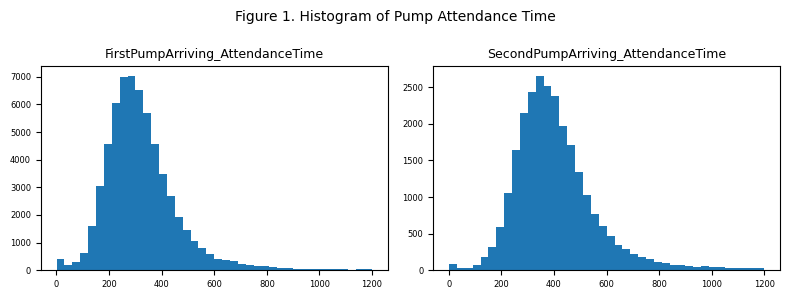

In [10]:
hist_df = cluster_df[['FirstPumpArriving_AttendanceTime', 'SecondPumpArriving_AttendanceTime']]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

for i, ax in zip(hist_df.columns, axes):
    ax.hist(cluster_df[i], bins=40)
    ax.set_title(i, fontsize=9)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='x', labelsize=6)

plt.suptitle('Figure 1. Histogram of Pump Attendance Time', fontsize=10)
plt.tight_layout()
plt.show()

<i>Figure 1</i> shows the histogram of the clustering features pertaining to pump attendance time. Both features exhibit a bell-shaped curve with minimal skewness.

#### Handling Null Values

Previously, it was discussed that null values are present for the `SecondPumpArriving_AttendanceTime` feature. In this section, the methodology for imputing these null values will be discussed.

In [11]:
cluster_df.isnull().sum()

FirstPumpArriving_AttendanceTime       626
SecondPumpArriving_AttendanceTime    36701
NumStationsWithPumpsAttending           77
NumPumpsAttending                       77
PumpCount                               88
PumpHoursRoundUp                       104
Notional Cost (£)                      104
NumCalls                                 0
dtype: int64

The presence of null values for `FirstPumpArriving_AttendanceTime` can be observed above. It was decided to completely remove incidents with null `FirstPumpArriving_AttendanceTime` since this feature is relevant in clustering the dataset as it shows the time it takes for a pump to arrive at the scene of the incident. Since the goal of the analysis is to assess response time, having no data for this feature will affect the classification of the incidents; thus, rows with null `FirstPumpArriving_AttendanceTime` will be removed from the clustering data.

In [12]:
cluster_df = cluster_df[cluster_df['FirstPumpArriving_AttendanceTime'].notna()]
cluster_df.isnull().sum()

FirstPumpArriving_AttendanceTime         0
SecondPumpArriving_AttendanceTime    36075
NumStationsWithPumpsAttending            0
NumPumpsAttending                        0
PumpCount                                0
PumpHoursRoundUp                        16
Notional Cost (£)                       16
NumCalls                                 0
dtype: int64

In [13]:
query = """
SELECT DISTINCT
    NumPumpsAttending,
    SUM(CASE WHEN SecondPumpArriving_AttendanceTime IS NULL THEN 1 ELSE 0 END) null_second_pump_time
FROM incidents_202001_202308
WHERE IncidentGroup = 'Fire'
      AND FirstPumpArriving_AttendanceTime IS NOT NULL
      AND SecondPumpArriving_AttendanceTime IS NULL
GROUP BY 1
"""

pd.read_sql(query, conn)

NumPumpsAttending  null_second_pump_time
0                1.0                  34800
1                2.0                   1195
2                3.0                     56
3                4.0                     19
4                5.0                      4
5                7.0                      1

Upon removing rows with null `FirstPumpArriving_AttendanceTime`, there are still null values for `SecondPumpArriving_AttendanceTime`. These will be imputed with `0` since having no value for this feature means that only one station attended the incident. In the cases where more than 1 pump attended the incident and only `FirstPumpArriving_AttendanceTime` is not null, this means that all pumps that showed up in the incident come from 1 station only. With all of this in mind, it was decided to impute null values for `SecondPumpArriving_AttendanceTime` with `0`.

Also, it can be observed that null values are also present for `PumpHoursRoundUp` and `Notional Cost (£)`. The first feature refers to the amount of time the pump was used in the incident and the second feature is dependent on this as this is the cost of using the pump. Having non-null values for these features is important as these reflect the efficiency of LFB in responding to the incident. With this, it was decided to remove rows in the dataset where `PumpHoursRoundUp` and `Notional Cost (£)` are null.

In [14]:
cluster_df = cluster_df[cluster_df[['PumpHoursRoundUp', 'Notional Cost (£)']].notna().all(axis=1)]
cluster_df['SecondPumpArriving_AttendanceTime'].fillna(0, inplace=True)

In [15]:
cluster_df.describe()

FirstPumpArriving_AttendanceTime  SecondPumpArriving_AttendanceTime  \
count                      62041.000000                       62041.000000   
mean                         322.813285                         170.014587   
std                          139.616575                         224.509324   
min                            1.000000                           0.000000   
25%                          234.000000                           0.000000   
50%                          301.000000                           0.000000   
75%                          383.000000                         352.000000   
max                         1199.000000                        1200.000000   

       NumStationsWithPumpsAttending  NumPumpsAttending     PumpCount  \
count                   62041.000000       62041.000000  62041.000000   
mean                        1.481504           1.650296      1.928289   
std                         0.855191           0.982182      2.684615   
min                         1.000000           1.000000      1.000000   
25%                         1.000000           1.000000      1.000000   
50%                         1.000000           1.000000      1.000000   
75%                         2.000000           2.000000      2.000000   
max                        14.000000          14.000000    156.000000   

       PumpHoursRoundUp  Notional Cost (£)      NumCalls  
count      62041.000000       62041.000000  62041.000000  
mean           2.460808         880.193098      2.179994  
std           10.442433        3723.103279      3.447004  
min            1.000000         339.000000      1.000000  
25%            1.000000         352.000000      1.000000  
50%            1.000000         364.000000      1.000000  
75%            2.000000         704.000000      2.000000  
max          680.000000      247520.000000    124.000000

#### Final DataFrame Preparation and Outlier Removal

In [2]:
query = """
SELECT
        IncidentNumber,
        IncidentGroup,
        CalYear CallYear,
        CAST(SUBSTR(DateOfCall, 6, 2) AS INTEGER) CallMonth,
        CAST(SUBSTR(DateOfCall, 9, 2) AS INTEGER) AS CallDay,
        HourOfCall HourOfCall,
        strftime('%Y-%m-%d', DateOfCall) DateOfCall,
        strftime('%H:%M:%S', TimeOfCall) TimeOfCall,
        IncGeo_BoroughName as borough,
        IncGeo_WardName as ward,
        IncidentStationGround,
        FirstPumpArriving_DeployedFromStation,
        SecondPumpArriving_DeployedFromStation,
        PropertyCategory,
        PropertyType,
        FirstPumpArriving_AttendanceTime as first_pump_time,
        SecondPumpArriving_AttendanceTime as second_pump_time,
        NumStationsWithPumpsAttending as num_of_station_pumps,
        NumPumpsAttending as num_pumps,
        PumpCount as pump_cnt,
        PumpHoursRoundUp as pump_hrs_rnd_up,
        "Notional Cost (£)" as notional_cost,
        NumCalls as num_calls,
        Latitude as lat,
        Longitude as long
FROM incidents_202001_202308
WHERE IncidentGroup = 'Fire'
      AND FirstPumpArriving_AttendanceTime IS NOT NULL
      AND PumpHoursRoundUp IS NOT NULL
      AND "Notional Cost (£)" IS NOT NULL
      AND PumpCount >= NumPumpsAttending
"""

trimmed_df = pd.read_sql(query, conn)
# trimmed_df.head()

NameError: name 'pd' is not defined

In [17]:
trimmed_df['second_pump_time'] = trimmed_df['second_pump_time'].fillna(0)

In [19]:
trimmed_df.describe()

CallYear     CallMonth       CallDay    HourOfCall  \
count  61917.000000  61917.000000  61917.000000  61917.000000   
mean    2021.384030      6.163477     15.706123     14.039747   
std        1.070671      3.065196      8.838160      6.308699   
min     2020.000000      1.000000      1.000000      0.000000   
25%     2020.000000      4.000000      8.000000     10.000000   
50%     2021.000000      6.000000     16.000000     15.000000   
75%     2022.000000      8.000000     23.000000     19.000000   
max     2023.000000     12.000000     31.000000     23.000000   

       first_pump_time  second_pump_time  num_of_station_pumps     num_pumps  \
count     61917.000000      61917.000000          61917.000000  61917.000000   
mean        322.731269        170.235412              1.480240      1.649208   
std         139.565046        224.525337              0.855254      0.982524   
min           1.000000          0.000000              1.000000      1.000000   
25%         234.000000          0.000000              1.000000      1.000000   
50%         301.000000          0.000000              1.000000      1.000000   
75%         383.000000        352.000000              2.000000      2.000000   
max        1199.000000       1200.000000             14.000000     14.000000   

           pump_cnt  pump_hrs_rnd_up  notional_cost     num_calls  \
count  61917.000000     61917.000000   61917.000000  61917.000000   
mean       1.929761         2.463330     881.095030      2.181162   
std        2.686976        10.452707    3726.766009      3.449025   
min        1.000000         1.000000     339.000000      1.000000   
25%        1.000000         1.000000     352.000000      1.000000   
50%        1.000000         1.000000     364.000000      1.000000   
75%        2.000000         2.000000     704.000000      2.000000   
max      156.000000       680.000000  247520.000000    124.000000   

                lat          long  
count  42795.000000  42795.000000  
mean      51.440585     -0.105707  
std        1.880012      0.165599  
min        0.000000     -0.510069  
25%       51.463351     -0.208654  
50%       51.515002     -0.096519  
75%       51.558514      0.006364  
max       51.690015      0.309261

Recorded incidents in the dataset where `PumpCount` is less than `NumPumpsAttending` will be removed from the clustering dataset since it is assumed that one `NumPumpsAttending` is to one `PumpCount`. With this, having a lesser value for `PumpCount` does not seem reasonable.

On the other hand, cases where `NumPumpsAttending` is greater than `PumpCount` are retained since the assumption stated earlier is satisfied; however, this may reflect inefficiencies in the current process of LFB since this scenario indicates that some fire trucks were not utilized during the incident or more fire trucks than the initial respondets were required to attend to the fires.

## Analysis

### Prepare and Split Dataset for Exploration and Final Analysis 

Data preparation methodology:
- Prepare query getting important columns from `incidents_202001_202308` table in `lfb.db` and apply the final filters (already done above)
- Get all numeric columns and apply StandardScaler
- Optional: save `df_prep` as local file
- Return tuples `df_prep` and `df_orig`
    - `df_prep` - for dimenionality reduction and clustering
    - `df_orig` - to label after clustering and labelling

Using function <u>prep_data_for_clustering2</u> to prepare and split data for <u>exploration</u> and <u>final processing</u>

- `final_df` - all dates (2020-2023)
- `explore_df` - Jan, Feb, March 2023 only

In [20]:
def prep_data_for_clustering2(input_df, explore):
    if explore:
        filtered_df = input_df[
            (input_df['CallYear'] == 2023) & 
            (input_df['CallMonth'].isin([1, 2, 3]))
        ]
        numeric_cols = filtered_df.select_dtypes(include='number')
        numeric_cols.drop(
            columns=['CallYear', 'CallMonth', 'CallDay', 'HourOfCall', 'lat', 'long'],
            inplace=True,
        )
        standard_scaler = StandardScaler()
        numeric_cols_scaled = standard_scaler.fit_transform(numeric_cols.to_numpy())
        df_prep = pd.DataFrame(numeric_cols_scaled, index=numeric_cols.index, columns=list(numeric_cols.columns))
        return df_prep, filtered_df
    else:
        numeric_cols = input_df.select_dtypes(include='number')
        numeric_cols.drop(
            columns=['CallYear', 'CallMonth', 'CallDay', 'HourOfCall', 'lat', 'long'],
            inplace=True,
        )
        standard_scaler = StandardScaler()
        numeric_cols_scaled = standard_scaler.fit_transform(numeric_cols.to_numpy())
        df_prep = pd.DataFrame(numeric_cols_scaled, index=numeric_cols.index, columns=list(numeric_cols.columns))
        return df_prep, input_df

In [21]:
final_df = prep_data_for_clustering2(trimmed_df, False)
explore_df = prep_data_for_clustering2(trimmed_df, True)

### Exploration of Different Clustering Methods

#### Dimensionality Reduction

Using PCA to reduce dimensions of LFB Dataset (explore)

In [22]:
explore_pca = PCA(n_components=3, random_state=1337)
explore_new = explore_pca.fit_transform(explore_df[0].values)
explore_orig, explore_compare = explore_df

In [23]:
explore_combs = list(combinations([i+1 for i in range(3)], 2))
print(f"Combinations {explore_combs}")

Combinations [(1, 2), (1, 3), (2, 3)]


Using helper function <u>display_pca_views</u> from <u>clustering.py</u> to display cluster views

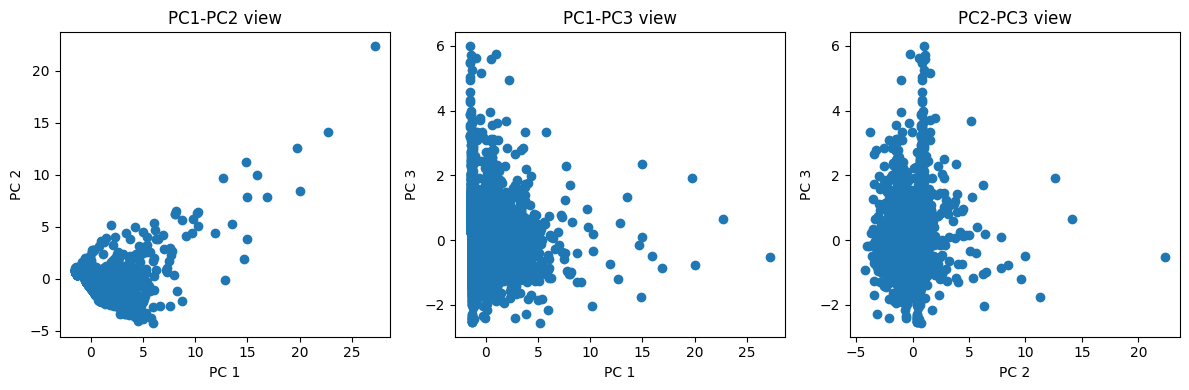

In [24]:
display_pca_views(explore_combs, explore_new, None)

PCA with 3 components explains 82.35% of the variance

In [25]:
explore_var_ex = np.sum(explore_pca.explained_variance_ratio_)
print(f"Variance Explained: {explore_var_ex*100:.2f}%")

Variance Explained: 82.38%


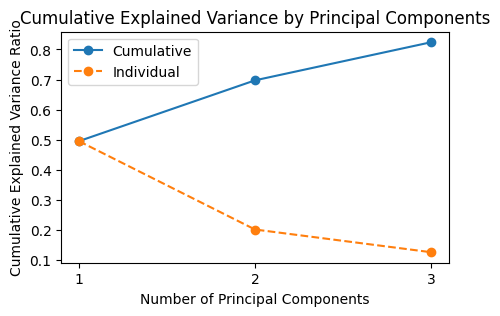

In [26]:
cumulative_variance_ratio = np.cumsum(explore_pca.explained_variance_ratio_)

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', label='Cumulative')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), explore_pca.explained_variance_ratio_, marker='o', linestyle='--', label='Individual')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.legend()
plt.show()

#### Density-Based

##### DBSCAN

Using helper function <u>get_kdist</u> from <u>clustering.py</u> to display kdist graph

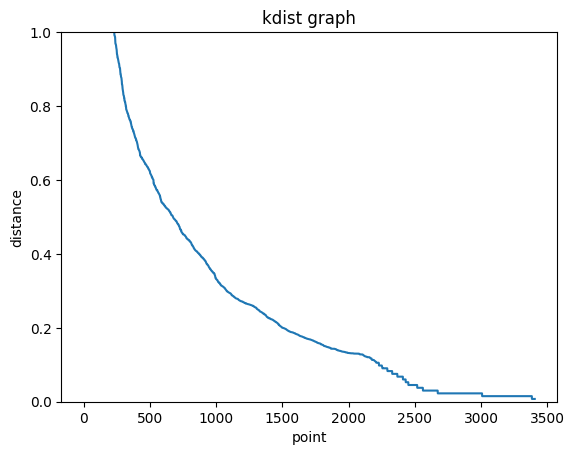

In [27]:
plt.plot(get_kdist(17, explore_new))
plt.title("kdist graph")
plt.xlabel("point")
plt.ylabel("distance")
plt.ylim(0, 1)
plt.show()

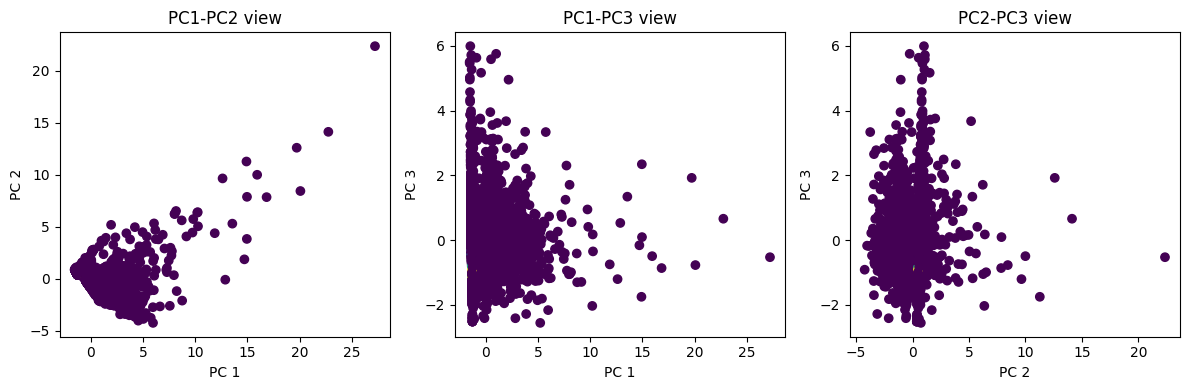

Number of clusters: 8
Number of noise points: 3269
Number of points in the largest cluster: 22
[21 22 16 17 19 16 17  9]
Number of points: 3406


In [28]:
dbscan = DBSCAN(eps=0.01, min_samples=16)
cluster_labels = dbscan.fit_predict(explore_new)

display_pca_views(explore_combs, explore_new, cluster_labels)

print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print(np.bincount(cluster_labels[cluster_labels >= 0]))
print("Number of points:", len(cluster_labels))

##### OPTICS

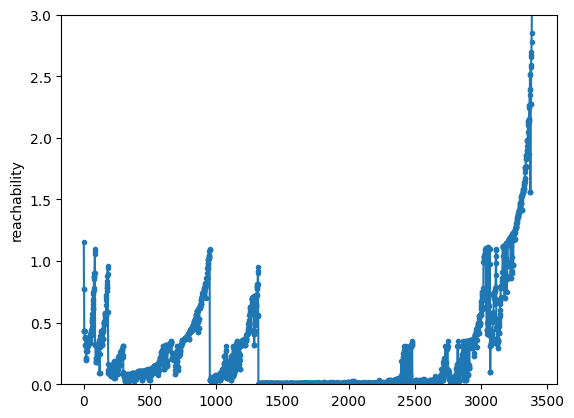

In [29]:
optics = OPTICS(min_samples=4, cluster_method="dbscan")
optics.fit(explore_orig)
plt.plot(optics.reachability_[optics.ordering_], ".-")
plt.ylim(0, 3)
plt.ylabel("reachability")
plt.show()

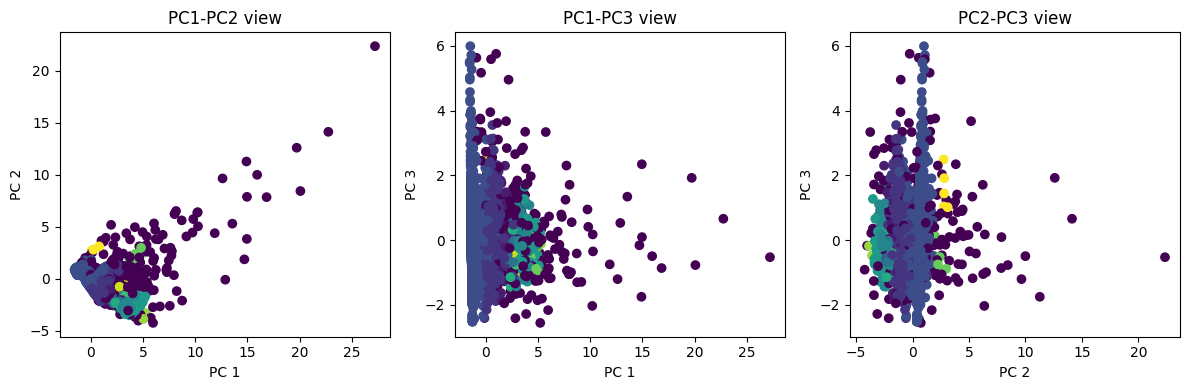

Number of clusters: 13
Number of noise points: 244
Number of points in the largest cluster: 2068
[  82  855 2068   16   14   46   48    7    4   10    3    4    5]
Number of points: 3406
Silhouette score: 0.2830375939873879


In [30]:
cluster_labels = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=1,
)

display_pca_views(explore_combs, explore_new, cluster_labels)

print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print(np.bincount(cluster_labels[cluster_labels >= 0]))
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(explore_orig, cluster_labels))

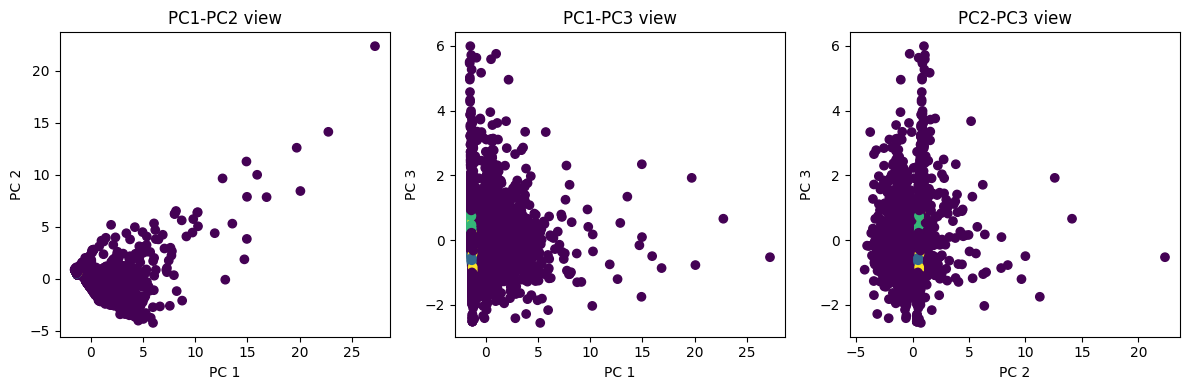

Number of clusters: 3
Number of noise points: 2849
Number of points in the largest cluster: 191
Number of points: 3406
Silhouette score: -0.19308349313437465


In [31]:
optics = OPTICS(
    min_samples=16, cluster_method="xi", xi=0.05, min_cluster_size=0.05
)
cluster_labels = optics.fit_predict(explore_orig)

display_pca_views(explore_combs, explore_new, cluster_labels)

print("Number of clusters:", cluster_labels.max() + 1)
print("Number of noise points:", (cluster_labels == -1).sum())
print(
    "Number of points in the largest cluster:",
    np.bincount(cluster_labels[cluster_labels >= 0]).max(),
)
print("Number of points:", len(cluster_labels))
print("Silhouette score:", silhouette_score(explore_orig, cluster_labels))

Looking at the expolaration results of Density-Based clustering methods it seems like they are not a match for the LFB dataset. It looks like there is only one clusters and the compactness and separation of the clusters as shown in the PC-views are inconclusive.

#### Representative-Based

##### K-Means

Using helper function <u>kmeans_proper</u> from <u>clustering.py</u> to display exploration of K-means clustering

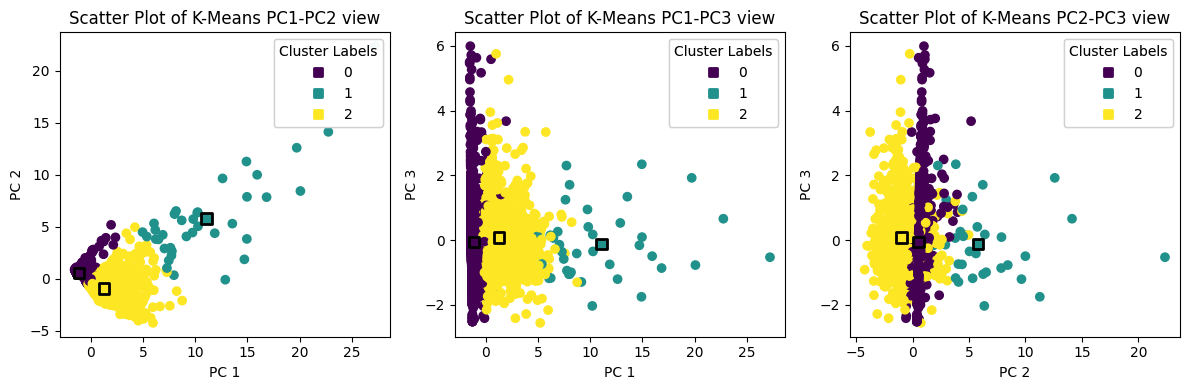

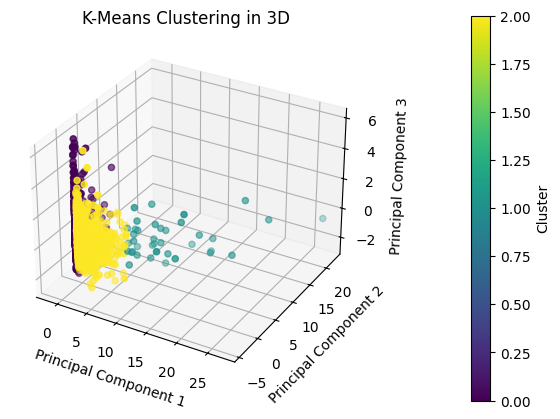

In [32]:
explore_kmeans = kmeans_proper(explore_combs, explore_pca, 3, explore_orig, explore_new)

Using helper functions <u>cluster_range</u>, <u>plot_clusters2</u> and <u>plot_internal</u> from <u>clustering.py</u> to display viz of different number of K and its internal validation criterion

In [33]:
explore_res = cluster_range(
    explore_orig.values, explore_kmeans, 2, 11
)

PC1-PC2


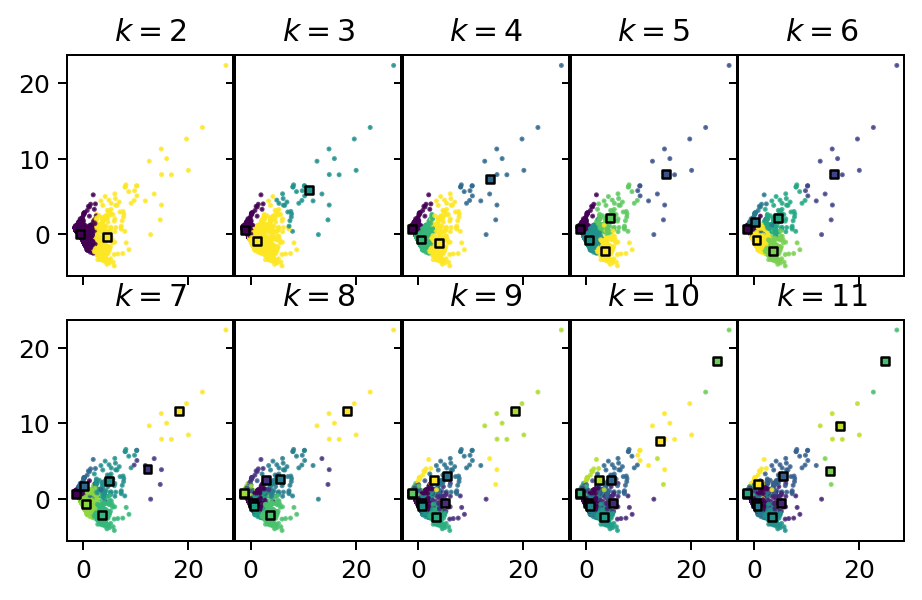

PC1-PC3


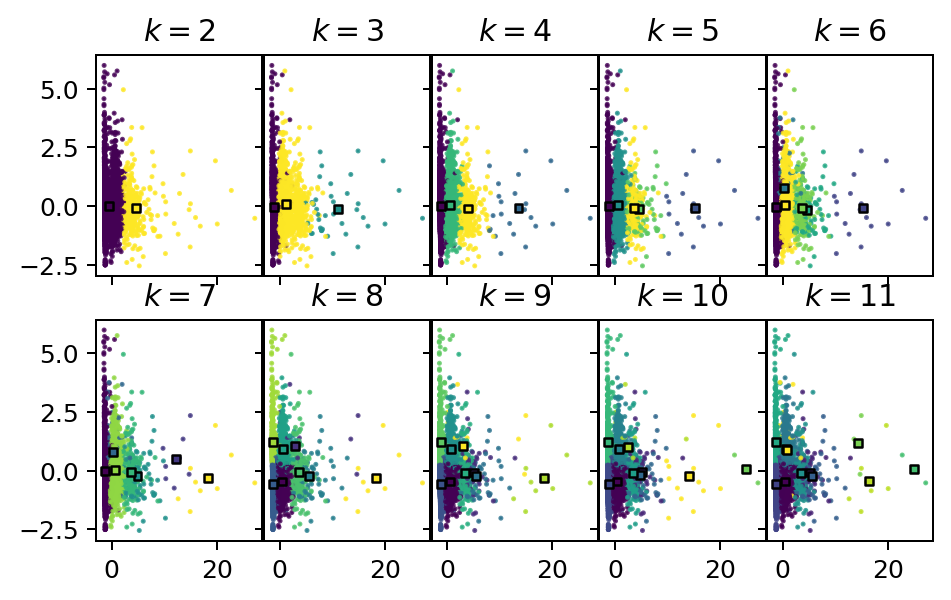

PC2-PC3


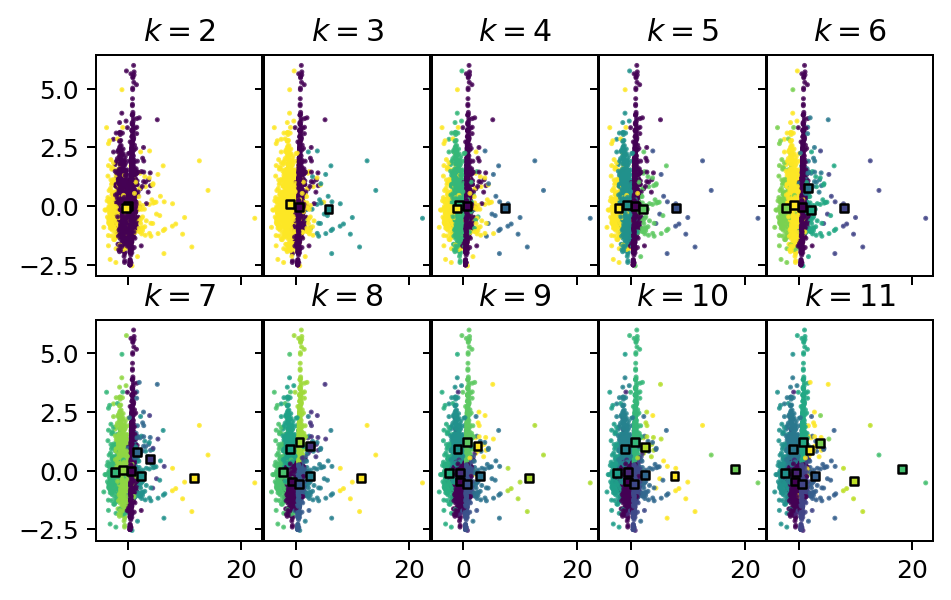

In [34]:
plot_clusters2(
    explore_combs, explore_new, explore_res['ys'], explore_res['centers'],
    explore_pca, ((6, 3.5), (6, 3.5), (6, 3.5)),
    180, True, True, True
)

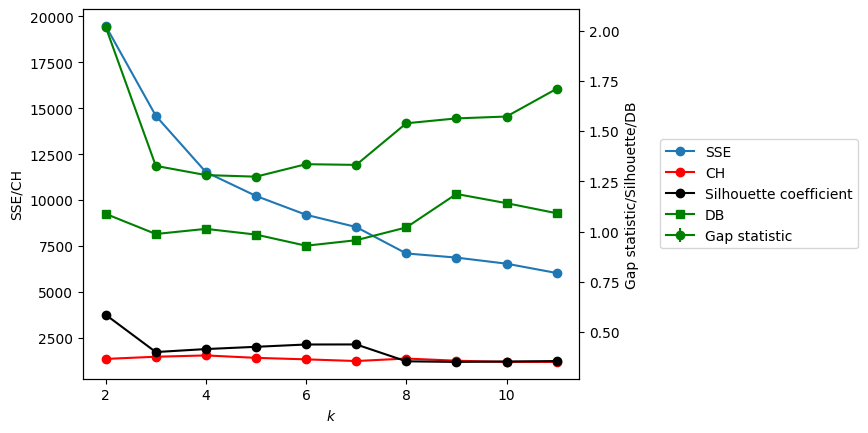

In [35]:
fig, ax = plt.subplots()
plot_internal(
    ax,
    explore_res["inertias"],
    explore_res["chs"],
    explore_res["scs"],
    explore_res["dbs"],
    explore_res["gss"],
    explore_res["gssds"],
)
plt.show()

Best k = 3
- Gap statistic elbow
- DB is minimum
- SC is minimum

K-means seems to be a very good choice of clustering method for the LFB dataset

##### K-Mediods (Skip)

Skipping K-Medioid exploration, explore dataset too big (Kernel always dies out)

#### Heirarchical-Based

Using helper functions <u>heirarch_cluster</u> from <u>clustering.py</u> to display different Heirarchical-Based Clustering types (Single, Average, Complete, Wards)

single


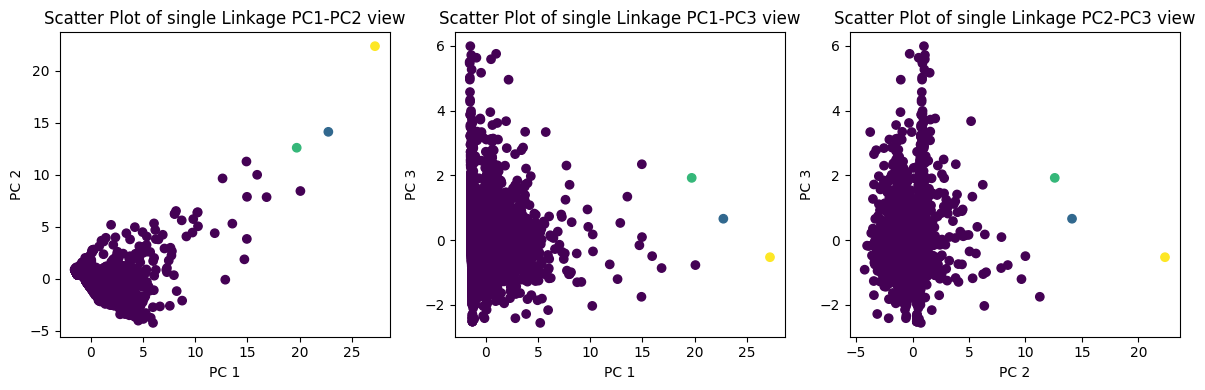

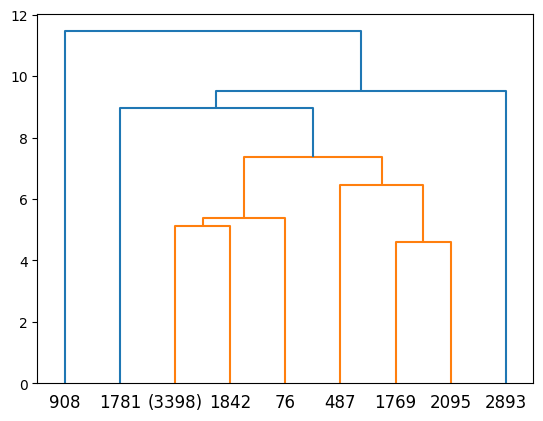

average


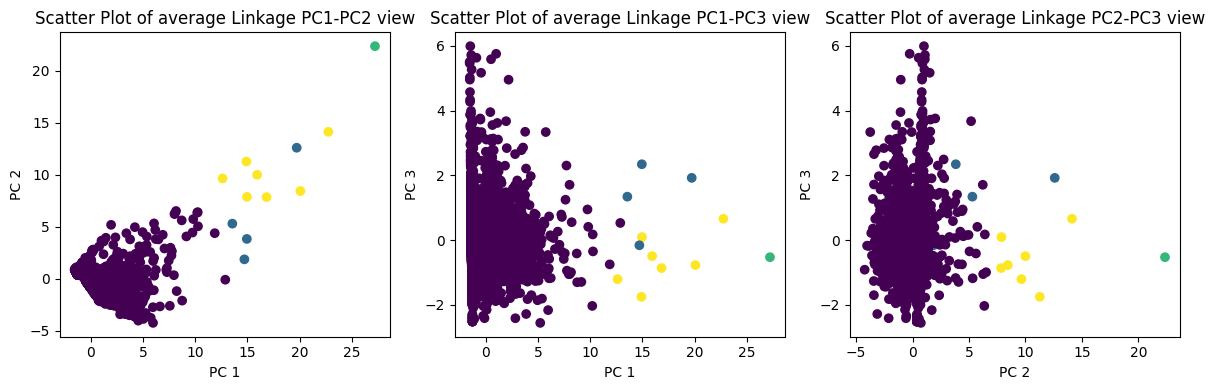

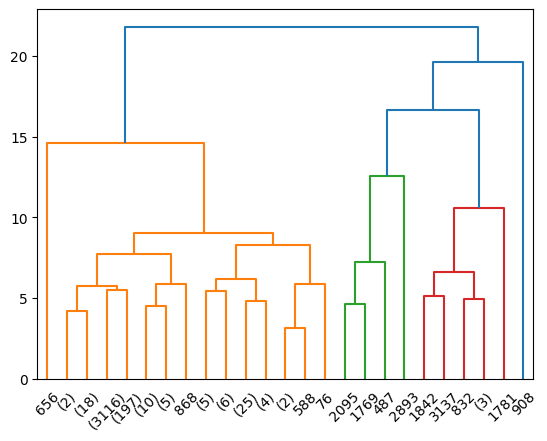

complete


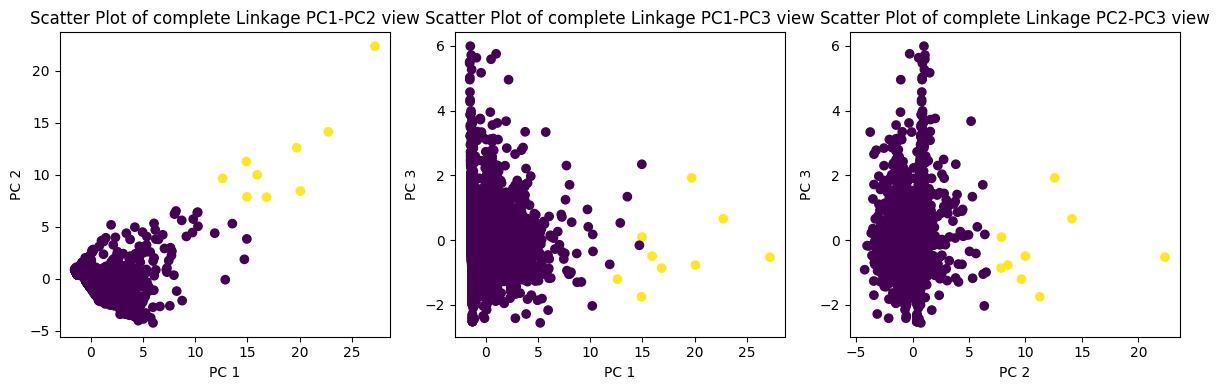

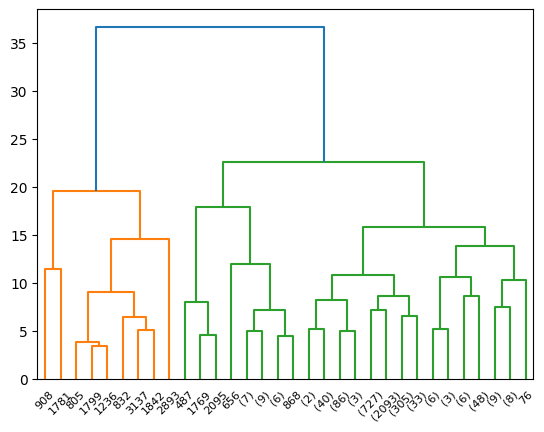

ward


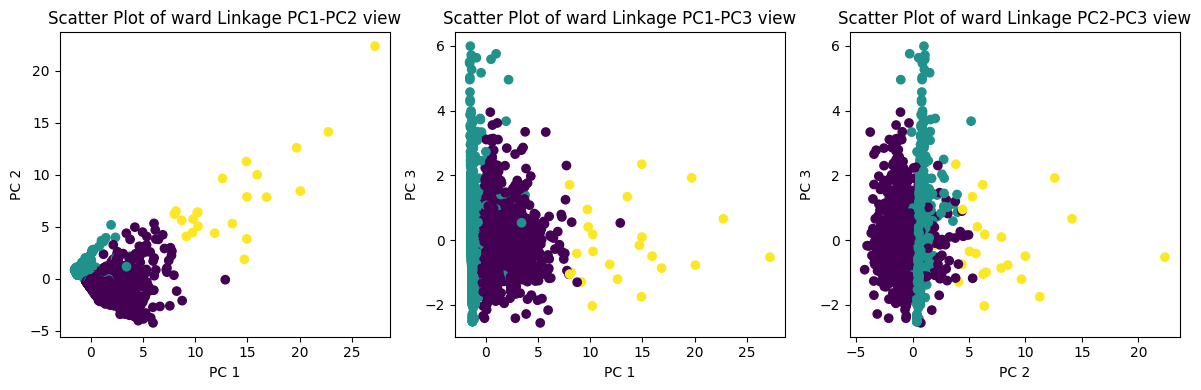

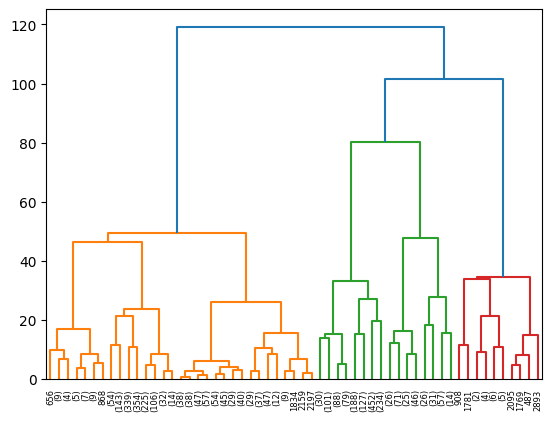

In [36]:
explore_heir_labels = []
# [('single', 11), ('average', 35), ('complete', 45), ('ward', 160)]
# [('single', 11), ('average', 35), ('complete', 45), ('ward', 160)]
# for i in [('single', 5), ('average', 8.1), ('complete', 12.5), ('ward', 75)]:
for i in [('single', 8), ('average', 15.1), ('complete', 25), ('ward', 90)]:
# for i in [('ward', 90)]:
    print(i[0])
    cluster_labels = heirarch_cluster(
        explore_combs, i[0], i[1], explore_orig.values, explore_new,
    )
    explore_heir_labels.append((i[0], cluster_labels))

It seems like most of the agglomerative methods are not a match for the LFB Dataset - except one of the agglomerative methods - <u>Ward's Method</u>. It looks pretty good in clustering the LFB dataset quite similar to K-Means. The team think this similarity is because of both methods clustering process aim to minimize within-cluster variance and maximize between-cluster variance to create separate and compact clusters.

Unfortunately when trying to run the whole dataset the kernel always dies. We will instead highlight the clusters on Ward's method on the exploration data in the next section.

#### Highlight on Ward's Method on a smaller subset of the LFB Dataset

Highlight on Ward's Method in Heirarchical clustering as it produced a good cluster visually similar to K-Means, although this clustering method can't handle the entire dataset (kernel dies), we'll highlight the cluster labels on the explore subset instead:

In [37]:
explore_wards_cluster_labels = explore_heir_labels[3][1]

In [38]:
explore_compare['wards cluster'] = explore_wards_cluster_labels

In [39]:
boroughs = explore_compare['borough'].unique().tolist()

#### Sidequest - Setup UK geojson for plotting choropleth map using plotly

In [40]:
with open('GB_local_authority.json', 'r') as f:
    local_auth = json.load(f)

local_auth_list = []
for i in range(len(local_auth["features"])):
    local_a = local_auth["features"][i]['properties']['LAD21NM']
    local_auth_list.append(local_a)
local_auth_list = [i for i in local_auth_list if i.upper() in boroughs]

#### Sidequest - Setup geopandas viz for London Boroughs

In [41]:
fp = 'London-wards-2018/London_Ward_CityMerged.shp'
df = gpd.read_file(fp)
grouped_gdf = df.dissolve(by='DISTRICT')
grouped_gdf = grouped_gdf.reset_index()
grouped_gdf['DISTRICT'] = grouped_gdf['DISTRICT'].str.lower()
grouped_gdf = grouped_gdf[['DISTRICT', 'geometry']]

#### Labelling  Clusters

Using helper functions <u>print_cluster_metrics</u> from <u>clustering.py</u> to display cluster metrics for labelling

In [42]:
stats_summary_list = []
cat_summary_list = []
plot_list = []
for n_cluster in set(explore_wards_cluster_labels):
    print_cluster_metrics(
        n_cluster, explore_compare, local_auth_list,
        local_auth, 'wards cluster', stats_summary_list,
        cat_summary_list, True, grouped_gdf, plot_list,
    )

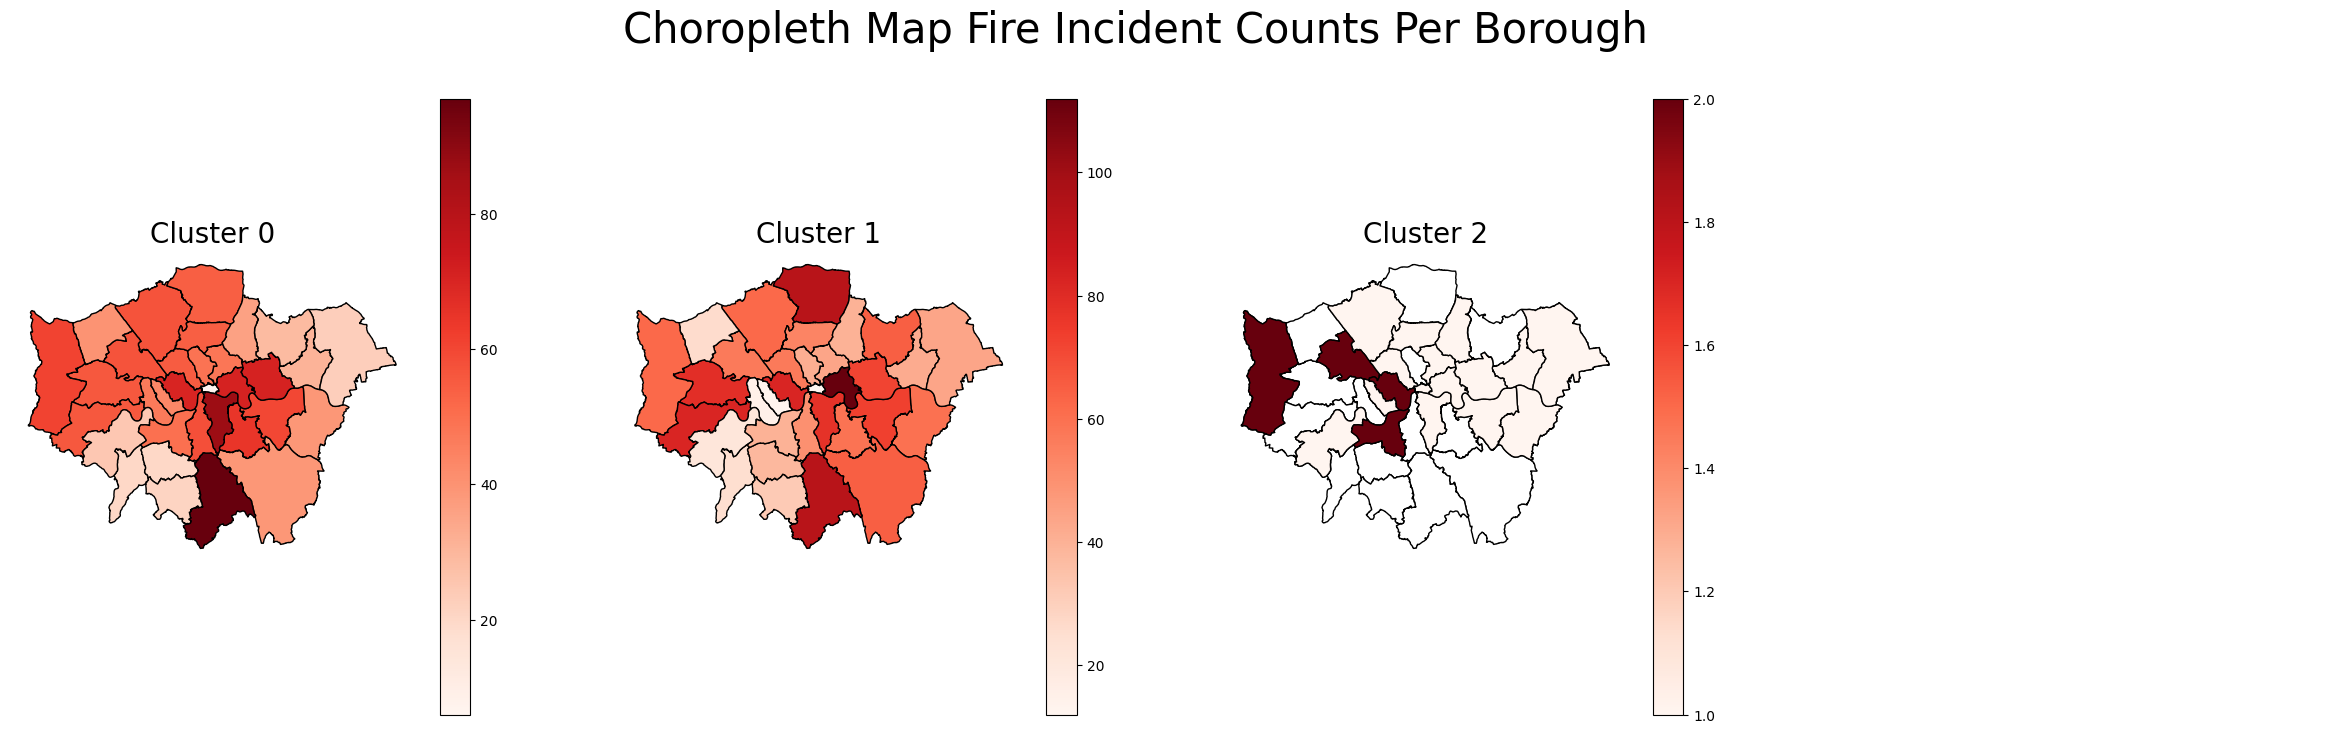

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(30, 8))

plot_list[0].plot(column='count', cmap='Reds', legend=True, ax=axs[0], edgecolor='black')
plot_list[1].plot(column='count', cmap='Reds', legend=True, ax=axs[1], edgecolor='black')
df.dissolve(by='DISTRICT').plot(ax=axs[2], color='white', edgecolor='black')
plot_list[2].plot(column='count', cmap='Reds', legend=True, ax=axs[2], edgecolor='black')
# plot_list[3].plot(column='count', cmap='Reds', legend=True, ax=axs[3], edgecolor='black')
axs[0].axis('off')
axs[0].set_title("Cluster 0", fontsize=20)
axs[1].axis('off')
axs[1].set_title("Cluster 1", fontsize=20)
axs[2].axis('off')
axs[2].set_title("Cluster 2", fontsize=20)
axs[3].axis('off')
# axs[3].set_title("Cluster 3", fontsize=20)
fig.text(0.5, 0.95, "Choropleth Map Fire Incident Counts Per Borough", ha='center', fontsize=30)
fig.show()

In [44]:
pd.options.display.float_format = format_with_commas
stat_summary = pd.concat(stats_summary_list, axis=0)
stat_summary = stat_summary.round(2)
cat_summary = pd.concat(cat_summary_list, axis=0)
cat_summary = cat_summary.round(2)
stat_summary = stat_summary.style.set_table_attributes(
    "style='display:inline'").set_caption(
    'Summary Statistics Per Cluster').set_table_styles(
    [dict(selector = "caption", 
               props = [("text-align", "left"), ('font-size', '30px')])])
cat_summary = cat_summary.style.set_table_attributes(
    "style='display:inline'").set_caption(
    'Categorical Summary Per Cluster').set_table_styles(
    [dict(selector = "caption", 
               props = [("text-align", "left"), ('font-size', '30px')])])
display(stat_summary)
display(cat_summary)
pd.options.display.float_format = None

Cluster 0
- Fires mostly from `Dwellings` property category, `House` property type, and mostly from `Croydon` borough
- Lowest ave. `first_pump_time`, highest ave. `second_pump_time`. Indicative of fastest response and longer fires

Cluster 1
- Fires mostly from `Outdoor Structure` property category, `Rubbish container` property type, and mostly from `Tower Hamlets` borough
- Highest ave. `first_pump_time`, lowest ave. `second_pump_time`. Indicative of slowest response and shorter fires

Cluster 2
- Low count means it's uncommon
- Fires mostly `Buildings` property type
- Highest `notional_cost`, `pump_cnt`, `pump_hrs_rnd_up` and `num_calls` - Indicative of a major fire that hit Major News.

#### Determining the best clustering methods to proceed

Proceeding to K-Means clustering proper as it has the best clustering visually and can handle the entire dataset.

### K-Means Proper

#### Dimensionality Reduction

In [45]:
final_pca = PCA(n_components=3, random_state=1337)
final_new = final_pca.fit_transform(final_df[0].values)
final_orig, final_compare = final_df

In [46]:
final_combs = list(combinations([i+1 for i in range(3)], 2))
print(f"Combinations {final_combs}")

Combinations [(1, 2), (1, 3), (2, 3)]


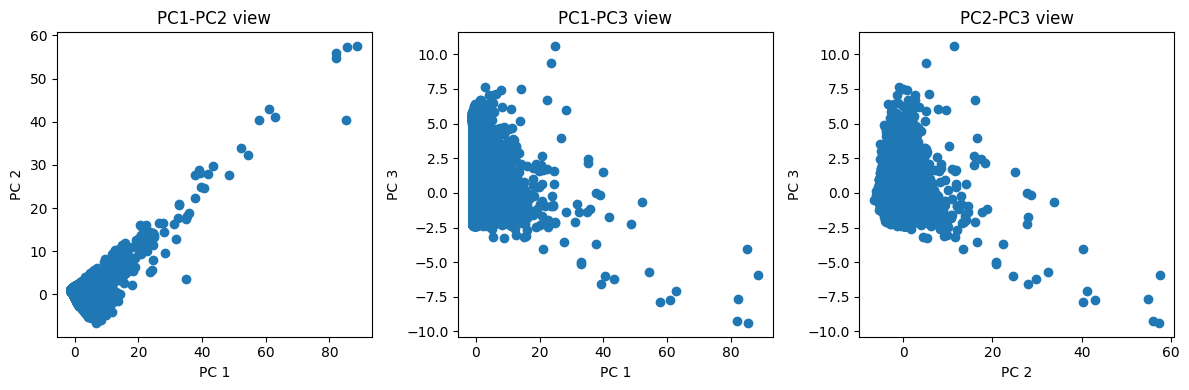

In [47]:
display_pca_views(final_combs, final_new, None)

PCA with 3 components explains 82.82% of the variance

In [48]:
final_var_ex = np.sum(final_pca.explained_variance_ratio_)
print(f"Variance Explained: {final_var_ex*100:.2f}%")

Variance Explained: 82.94%


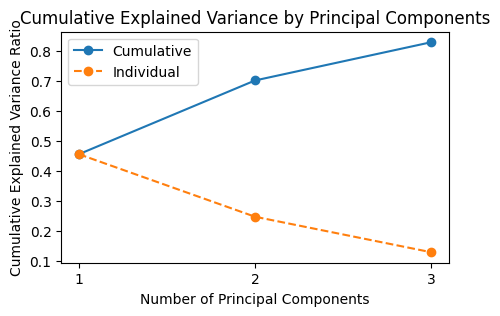

In [49]:
cumulative_variance_ratio = np.cumsum(final_pca.explained_variance_ratio_)

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', label='Cumulative')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), final_pca.explained_variance_ratio_, marker='o', linestyle='--', label='Individual')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, len(cumulative_variance_ratio) + 1))
plt.legend()
plt.show()

#### Clustering proper

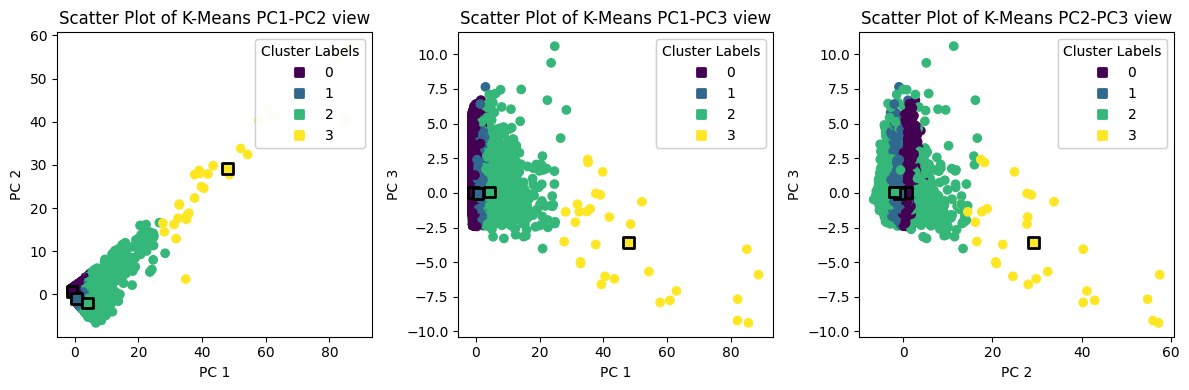

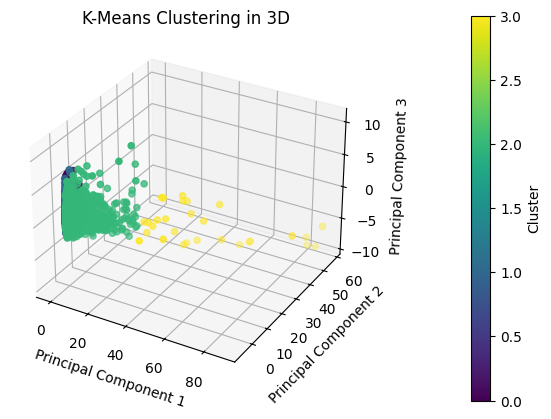

In [50]:
final_kmeans = kmeans_proper(
    final_combs, final_pca, 4, final_orig, final_new,
)

In [51]:
final_res = cluster_range(
    final_orig.values, final_kmeans, 2, 11
)

PC1-PC2


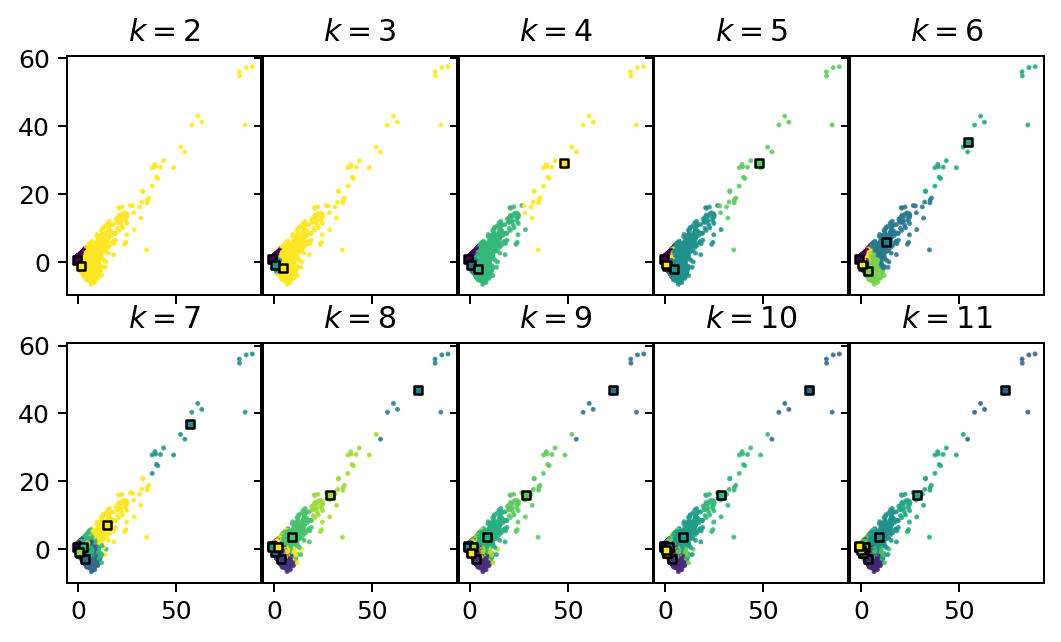

PC1-PC3


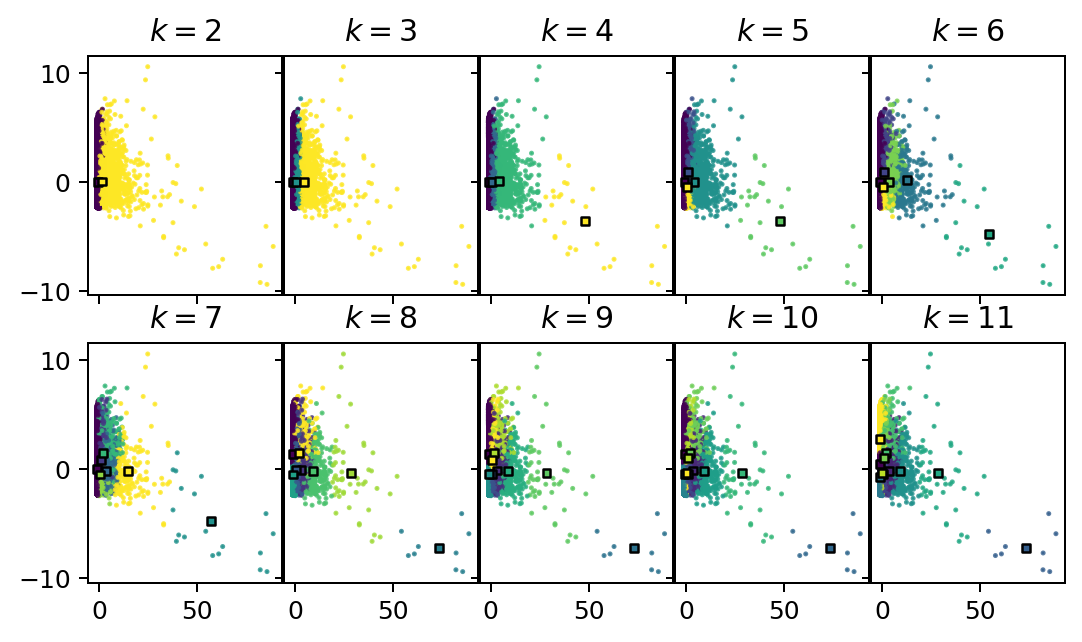

PC2-PC3


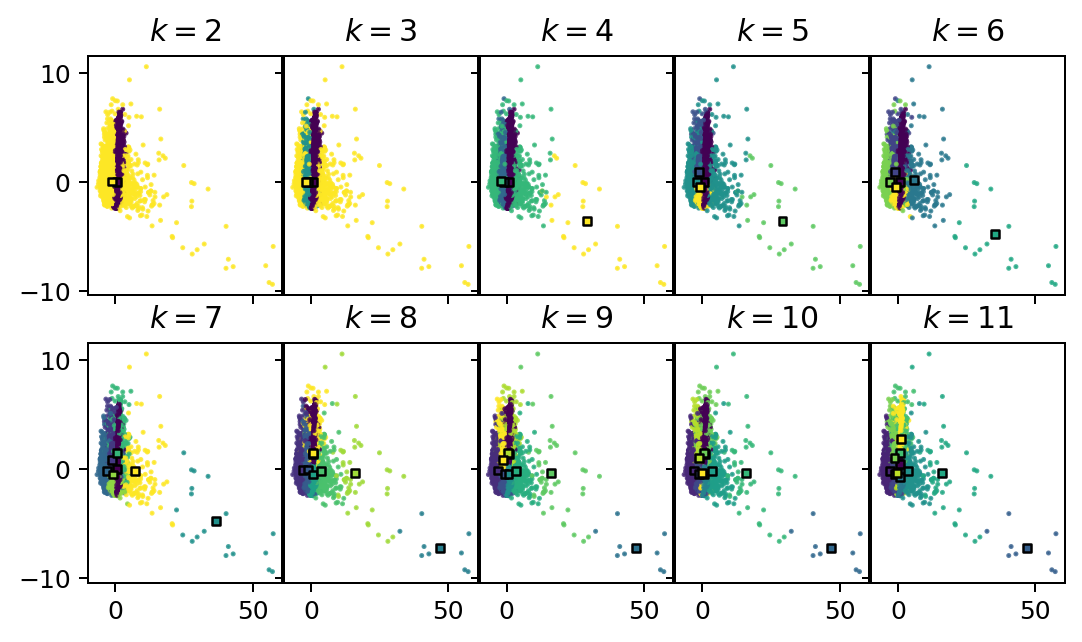

In [52]:
plot_clusters2(
    final_combs, final_new, final_res['ys'], final_res['centers'],
    final_pca, ((7, 3.8), (7, 3.8), (7, 3.8)),
    180, True, True, True
)

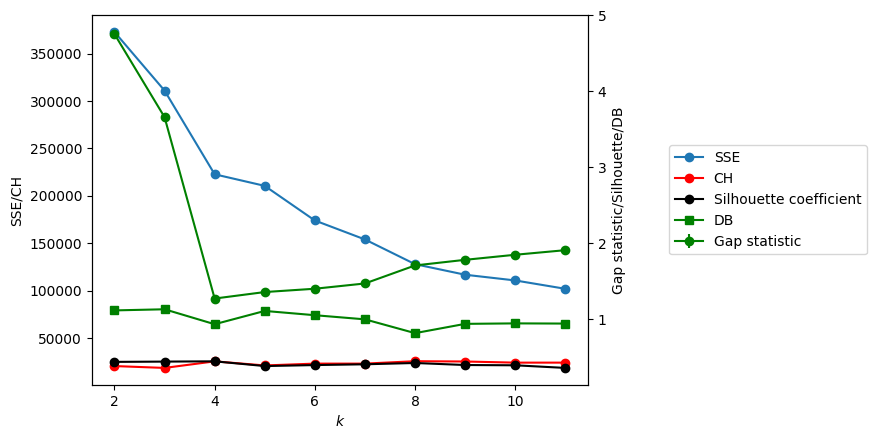

In [53]:
fig, ax = plt.subplots()
plot_internal(
    ax,
    final_res["inertias"],
    final_res["chs"],
    final_res["scs"],
    final_res["dbs"],
    final_res["gss"],
    final_res["gssds"],
)
plt.show()

Best k = 4
- Gap statistic and SSE elbow
- DB is minimum
- SC is minimum

#### Labeling Clusters

In [54]:
final_compare['kmeans cluster'] = final_kmeans.labels_

In [55]:
final_compare.to_csv('cluster_labels.csv')

In [56]:
stats_summary_list = []
cat_summary_list = []
plot_list = []
for n_cluster in set(final_kmeans.labels_):
    print_cluster_metrics(
        n_cluster, final_compare, local_auth_list,
        local_auth, 'kmeans cluster', stats_summary_list,
        cat_summary_list, True, grouped_gdf, plot_list,
    )

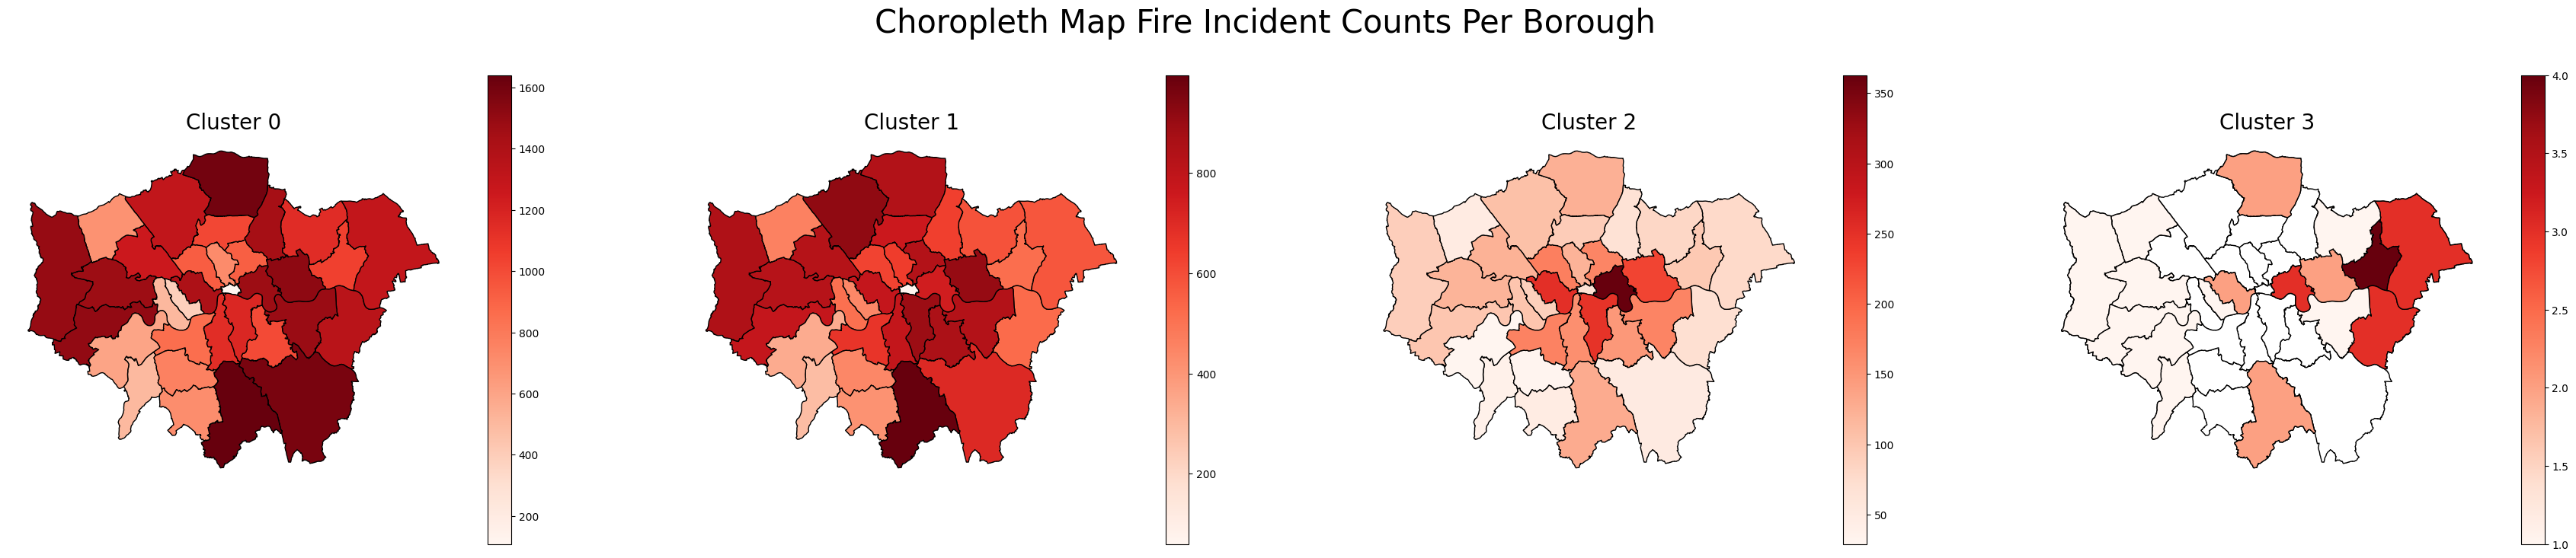

In [57]:
fig, axs = plt.subplots(1, 4, figsize=(44, 8))

plot_list[0].plot(column='count', cmap='Reds', legend=True, ax=axs[0], edgecolor='black')
plot_list[1].plot(column='count', cmap='Reds', legend=True, ax=axs[1], edgecolor='black')
plot_list[2].plot(column='count', cmap='Reds', legend=True, ax=axs[2], edgecolor='black')
df.dissolve(by='DISTRICT').plot(ax=axs[3], color='white', edgecolor='black')
plot_list[3].plot(column='count', cmap='Reds', legend=True, ax=axs[3], edgecolor='black')
axs[0].axis('off')
axs[0].set_title("Cluster 0", fontsize=20)
axs[1].axis('off')
axs[1].set_title("Cluster 1", fontsize=20)
axs[2].axis('off')
axs[2].set_title("Cluster 2", fontsize=20)
axs[3].axis('off')
axs[3].set_title("Cluster 3", fontsize=20)
fig.text(0.5, 0.95, "Choropleth Map Fire Incident Counts Per Borough", ha='center', fontsize=30)
fig.show()

In [58]:
pd.options.display.float_format = format_with_commas
stat_summary = pd.concat(stats_summary_list, axis=0)
stat_summary = stat_summary.round(2)
cat_summary = pd.concat(cat_summary_list, axis=0)
cat_summary = cat_summary.round(2)
stat_summary = stat_summary.style.set_table_attributes(
    "style='display:inline'").set_caption(
    'Summary Statistics Per Cluster').set_table_styles(
    [dict(selector = "caption", 
               props = [("text-align", "left"), ('font-size', '30px')])])
cat_summary = cat_summary.style.set_table_attributes(
    "style='display:inline'").set_caption(
    'Categorical Summary Per Cluster').set_table_styles(
    [dict(selector = "caption", 
               props = [("text-align", "left"), ('font-size', '30px')])])
display(stat_summary)
display(cat_summary)
pd.options.display.float_format = None

Cluster 0
- Fires mostly from `Outdoor` property category, `Rubbish container` property type, and mostly from `Croydon` borough
- Second highes ave. `first_pump_time`, lowest ave. `second_pump_time`. Indicative of slow response and shortest fires
- Lowest `notional_cost`

Cluster 1
- Fires mostly from `Dwelling` property category, `House` property type, and mostly from `Croydon` borough
- Lowest ave. `first pump time`, second lowest ave. `second_pump_time`. Indicative of fastest response and short fires
- Low `notional_cost`

Cluster 2
- Fires mostly from `Dwelling` property category, `Purpose Built Flats/Maisonettes` property type, and mostly from `Tower Hamlets` borough
- Second lowest ave. `first pump time`, second highest ave. `second_pump_time`. Indicative of fast response and longer fires
- High `notional_cost`, `pump_cnt`, `pump_hrs_rnd_up` and `num_calls` - Indicative of serious fire incidents

Cluster 3
- Low count means it's uncommon
- Fires mostly `Warehouse` property type
- Highest `notional_cost`, `pump_cnt`, `pump_hrs_rnd_up` and `num_calls` - Indicative of a major fire that hit Major News.

## Results and Discussion

yadda

## Conclusions

yadda yadda yadda

## Recommendations

yadda yadda yadda

## References